# Report

## Imports

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import os

from preprocessing import filter_circles
from typing import Callable
from IPython.display import clear_output
from skimage.morphology import disk, closing, opening
from skimage.feature import match_template
from skimage.color import rgb2hsv



## Preprocessing

In [82]:
# download the data
#! kaggle competitions download -c iapr24-coin-counter
#! unzip iapr24-coin-counter.zip && rm iapr24-coin-counter.zip

# clear the output for cleaner notebook
clear_output()

## Hough Transform

In [3]:
img_path = 'train/1. neutral_bg/L1010277.JPG'

ref_chf_path = 'ref/ref_chf.JPG'
ref_eur_path = 'ref/ref_eur.JPG'

In [6]:
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv.resize(image, dim, interpolation=cv.INTER_AREA)
    return resized

In [5]:
img = cv.imread(ref_chf_path, cv.IMREAD_GRAYSCALE)
img_resized = resize_image(img, 10)

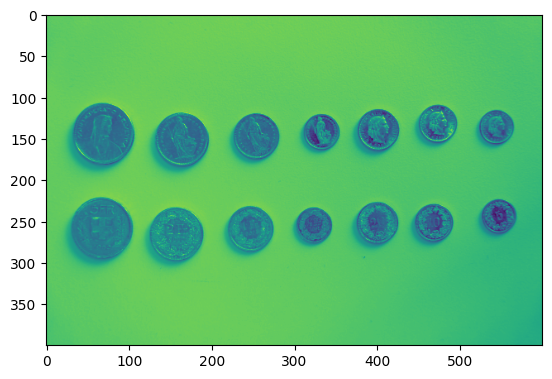

In [6]:
plt.imshow(img_resized)

In [7]:
img_blurred = cv.medianBlur(img_resized, 5)
cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50)

In [8]:
circles

array([[[ 68.5, 145.5,  37.3],
        [400.5, 252.5,  25.8],
        [162.5, 152.5,  33.5],
        [253.5, 147.5,  27.8],
        [ 66.5, 257.5,  36.2],
        [246.5, 260.5,  27.9],
        [401.5, 140.5,  25.8],
        [156.5, 264.5,  31.6],
        [545.5, 245.5,  22.4],
        [544.5, 139.5,  23.1],
        [323.5, 256.5,  21.8],
        [332.5, 143.5,  21.8],
        [473.5, 131.5,  22.3],
        [472.5, 251.5,  20.2]]], dtype=float32)

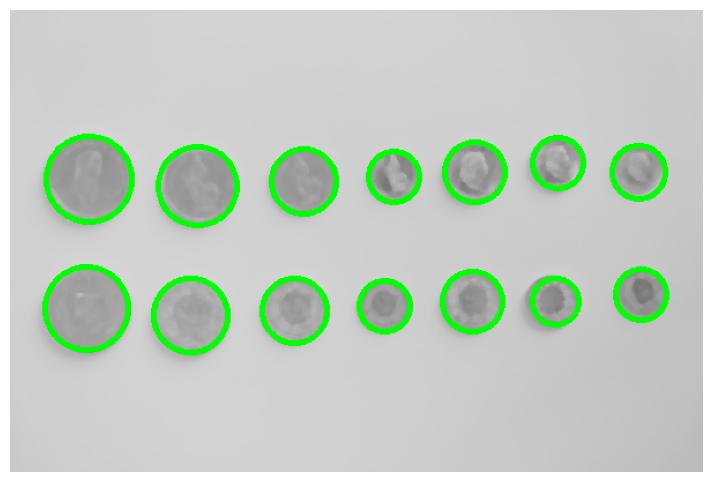

In [9]:
circles = np.uint16(np.around(circles))

for (x, y, r) in circles[0, :]:
        cv.circle(cimg, (x, y), r, (0, 255, 0), 4)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(cimg)
plt.axis('off')  # Hide the axis
plt.show()

In [10]:
# Ordering circles by radius
c = circles[0]
sorted_index = np.argsort(c[:, -1])
circles_sorted = c[sorted_index]

# finding max/min radii to provide better estimation in Hough transform
max_rad = np.max(circles_sorted[:, -1])
min_rad = np.min(circles_sorted[:, -1])
print(f"Max rad : {max_rad}\tMin rad : {min_rad}")


Max rad : 37	Min rad : 20


## Morphology

### Morphological functions

In [11]:
def apply_morphology(img_th, disk_radius, morphology):

    footprint = disk(disk_radius)
    return morphology(img_th, footprint)

def apply_closing(img_th, disk_radius):
    """
    Apply closing to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for closing

    Return
    ------
    img_closing: np.ndarray (M, N)
        Image after closing operation
    """
    footprint = disk(disk_radius)

    return closing(img_th, footprint)


def apply_opening(img_th, disk_radius):
    """
    Apply opening to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for opening

    Return
    ------
    img_opening: np.ndarray (M, N)
        Image after opening operation
    """
    footprint = disk(disk_radius)

    return opening(img_th, footprint)


### Closing

A single closing operation on a picture ran for more than 10 minutes...Unsustainable

In [12]:
# Taking list of problematic pictures
filenames = [f'L00000{i}.JPG' for i in range(60,71)]

test_path = 'test/'
hough_path = 'hough/'

# Iterating on each img

# dict of functions
morphology_functions = {'c': apply_closing, 'o':apply_opening}

# Coin radius range in [15:45]
disk_size = 100

'''
for filename in filenames:
	filepath = os.path.join(test_path, filename)
	
	print(f"Begin with {filepath}")
	
	if os.path.isfile(filepath):
		
		
		# Open img and apply morphology
		img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)

		# Apply selected morphology
		img_resized = resize_image(img, 10)
		
		img_morph = apply_closing(img, disk_size)
		#img_morph = apply_morphology(img_resized, disk_size, morphology_functions['c'])
		cv.imwrite(os.path.join(os.path.join(hough_path, filename)), img_morph)
		
		img_blurred = cv.medianBlur(img_resized, 5)
		cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

		# Find circles with and without educated radii guess
		circles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))
		c_prior = cv.HoughCircles(image=img_blurred, circles=cv.HOUGH_GRADIENT, method=1,  dp=20, minDist=min_rad, param1=70, param2=20, minRadius=min_rad, maxRadius=max_rad)
		circles_prior.append(c_prior)

		# Show circles on image and save
		c_prior_int = np.uint16(np.around(c_prior))

		for (x, y, r) in c_prior_int[0, :]:
			cv.imwrite(os.path.join(detect_dir_path, filename), cv.circle(cimg, (x, y), r, (0, 255, 0), 4))

		
		print(f"Done with {filename}")
		break
'''

'\nfor filename in filenames:\n\tfilepath = os.path.join(test_path, filename)\n\t\n\tprint(f"Begin with {filepath}")\n\t\n\tif os.path.isfile(filepath):\n\t\t\n\t\t\n\t\t# Open img and apply morphology\n\t\timg = cv.imread(filepath, cv.IMREAD_GRAYSCALE)\n\n\t\t# Apply selected morphology\n\t\timg_resized = resize_image(img, 10)\n\t\t\n\t\timg_morph = apply_closing(img, disk_size)\n\t\t#img_morph = apply_morphology(img_resized, disk_size, morphology_functions[\'c\'])\n\t\tcv.imwrite(os.path.join(os.path.join(hough_path, filename)), img_morph)\n\t\t\n\t\timg_blurred = cv.medianBlur(img_resized, 5)\n\t\tcimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)\n\n\t\t# Find circles with and without educated radii guess\n\t\tcircles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))\n\t\tc_prior = cv.HoughCircles(image=img_blurred, circles=cv.HOUGH_GRADIENT, method=1,  dp=20, minDist=min_rad, param1=70, param2=20, minRadius=min_rad, ma

## Template matching
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py

In [13]:
# Open template imgs
template_path = 'template'

### Single 2CHF coin on neutral background

In [14]:
# 2CHF template on Heads
template_filename = 'CHF_2_H.JPG'

# Test files
img_filenames = 'L0000001.JPG'

img = cv.imread(os.path.join(test_path, img_filenames), cv.IMREAD_GRAYSCALE)
template = cv.imread(os.path.join(template_path, template_filename), cv.IMREAD_GRAYSCALE)
#img_resized = resize_image(img, 10)

# Matching
result = match_template(img, template)

### Plot results

Coin is correctly found

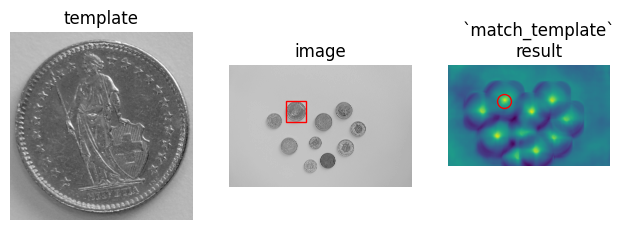

In [15]:
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(template, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = template.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

### Two 5CHF coins on a noisy background

Algorithm finds a coin where there is none, although there are 2 coins in the picture. Noise is clearly a limiting factor

In [16]:
# 5CHF tail template
template_filename = 'CHF_5_T.JPG'

# Test files
img_filenames = 'L0000002.JPG'


img = cv.imread(os.path.join(test_path, img_filenames), cv.IMREAD_GRAYSCALE)
template = cv.imread(os.path.join(template_path, template_filename), cv.IMREAD_GRAYSCALE)

# Matching
result = match_template(img, template)

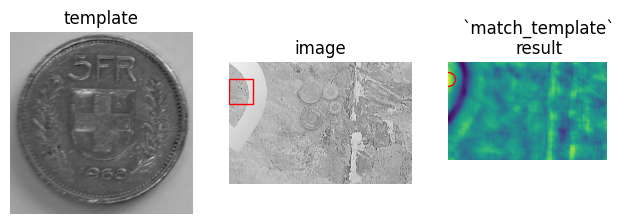

In [17]:
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(template, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = template.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

## Hough - Background denoising

### Thresholding background

Idea: find color space distribution of coins, threshold everything in img outside of this colorspace, so background is uniform and less prone to false positive

### Plotting functions from lab 1

In [ ]:
# Plot color space distribution 
def plot_colors_histo(
    img: np.ndarray,
    func: Callable,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    channels = func(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()


In [ ]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """
    data_red = np.copy(img[:, :, 0])
    data_green = np.copy(img[:, :, 1])
    data_blue = np.copy(img[:, :, 2])
    
    return data_red, data_green, data_blue



def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """
    img_hsv = rgb2hsv(np.copy(img))
    data_h = img_hsv[:, :, 0]
    data_s = img_hsv[:, :, 1]
    data_v = img_hsv[:, :, 2]
    
    return data_h, data_s, data_v

# Plot color space distribution 
def plot_thresholded_image(
    img: np.ndarray,
    func: Callable,
    title: str,
):
    """
    Plot the original image and its thresholded version

    Args
    ----
    img: np.ndarray (M, N, 3)
        Input image of shape MxNx3.
    func: Callable
        Thresholded image.
    title: str
        Title of the plot
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img)
    axes[1].imshow(func(img))
    [a.axis('off') for a in axes]
    plt.suptitle(title)
    plt.tight_layout()

### Plotting coins RGB

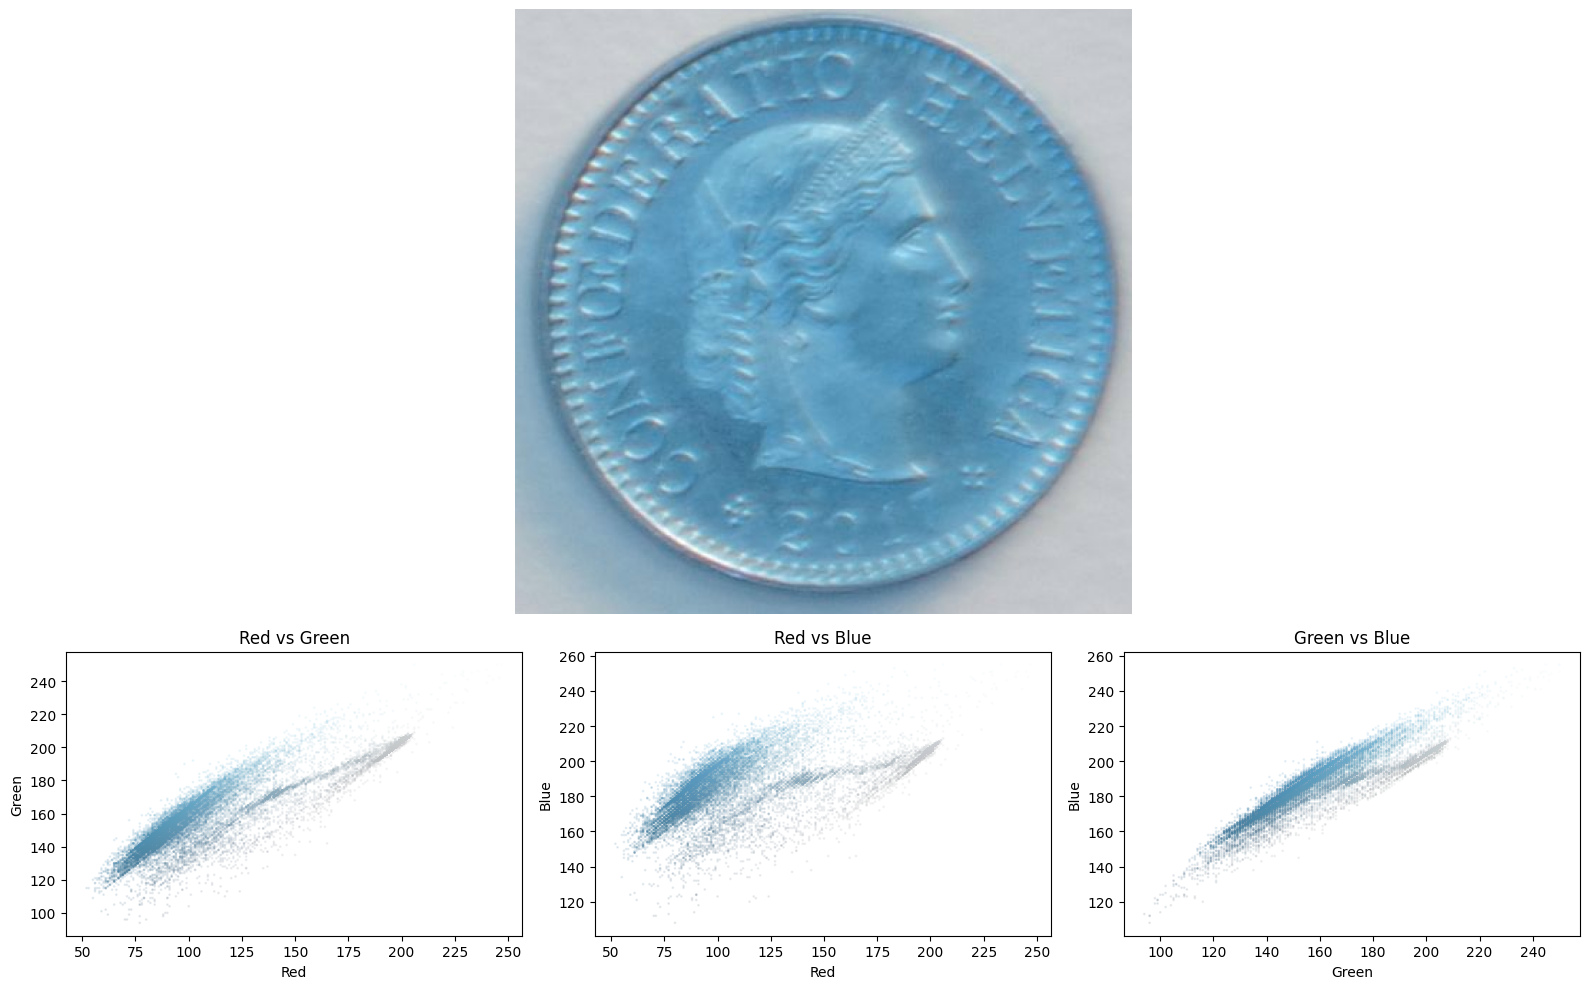

In [ ]:
# 2CHF template on Heads
template_filename = 'CHF_005_H.jpg'

template = cv.imread(os.path.join(template_path, template_filename))

# Call plotting function with your implemented function
plot_colors_histo(
    img = template,
    func = extract_rgb_channels,
    labels = ["Red", "Green", "Blue"],
)

### Plotting coins HSV

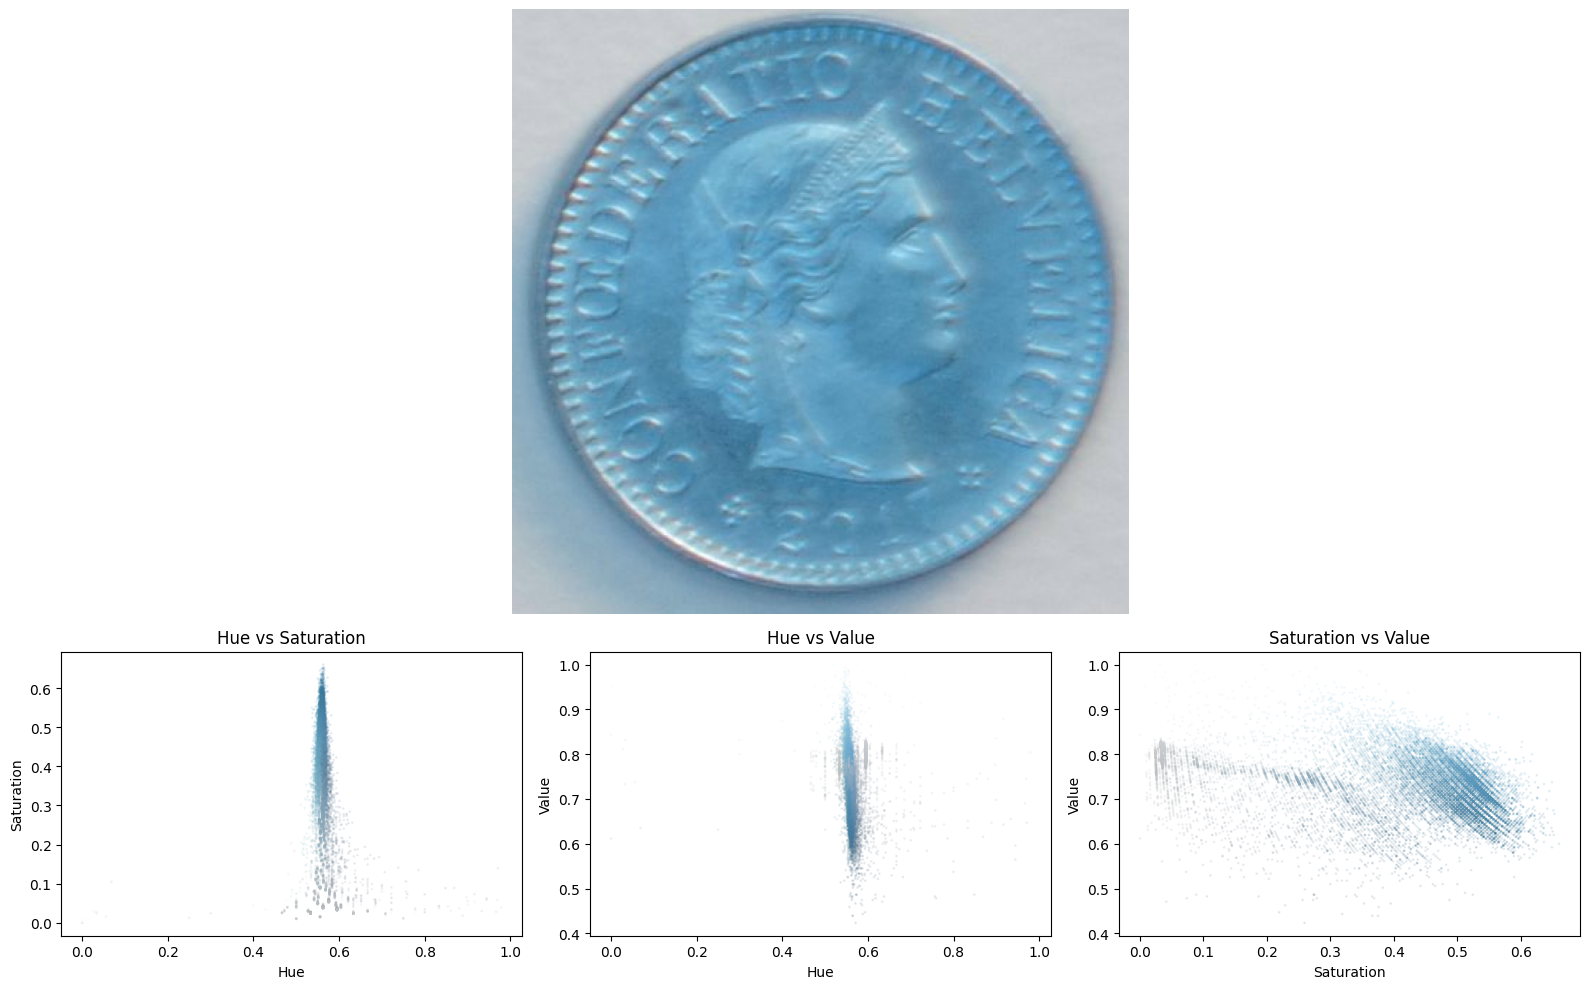

In [ ]:
# 2CHF template on Heads
template_filename = 'CHF_005_H.JPG'

template = cv.imread(os.path.join(template_path, template_filename))

# Call plotting function with your implemented function
plot_colors_histo(
    img = template,
    func = extract_hsv_channels,
    labels = ["Hue", "Saturation", "Value"],
)

### Plotting noisy background color distributions

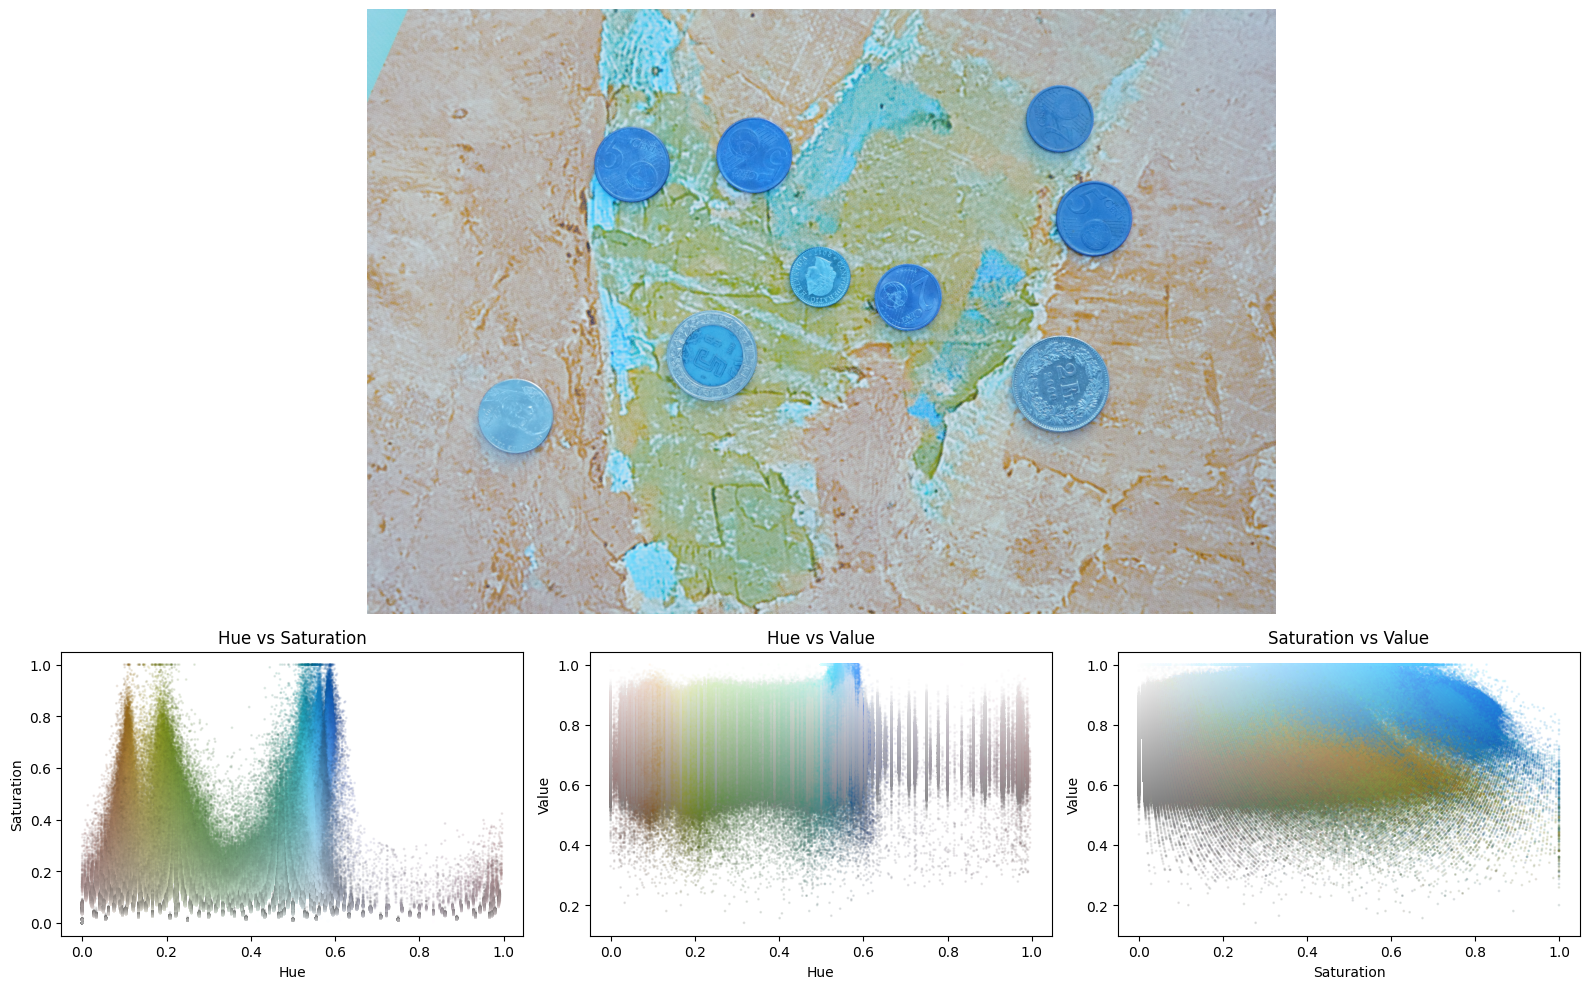

In [ ]:
# Noisy background
filename_path = os.path.join('test','L0000033.JPG')

file = cv.imread(filename_path)

# Call plotting function with your implemented function
plot_colors_histo(
    img = file,
    func = extract_hsv_channels,
    labels = ["Hue", "Saturation", "Value"],
)

### Thresholded image to remove background

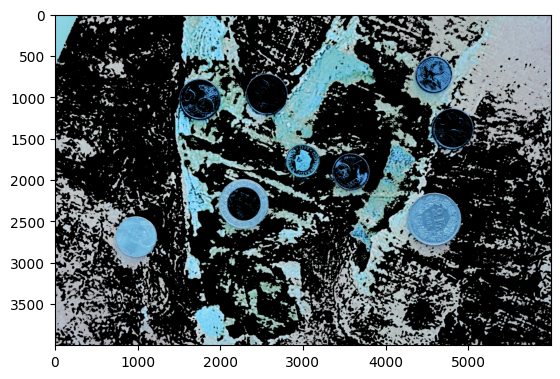

In [ ]:
def apply_hsv_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """
    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)

    hue_min = 0.4
    hue_max = 0.7

    sat_min = 0.0
    sat_max = 0.7

    val_min = 0.4
    val_max = 1.0
    
    #img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    hue_mask = cv.inRange(data_h, hue_min, hue_max)
    saturation_mask = cv.inRange(data_s, sat_min, sat_max)
    value_mask = cv.inRange(data_v, val_min, val_max)

    final_mask = cv.bitwise_and(hue_mask, cv.bitwise_and(saturation_mask, value_mask))

    # Apply the mask to the original image
    result = cv.bitwise_and(img, img, mask=final_mask)
    
    return  result

img_thresholded = apply_hsv_threshold(file)
plt.imshow(img_thresholded)

(4000, 6000, 3)


### Hough on thresholded

In [ ]:
img_thresholded_gray = cv.cvtColor(img_thresholded, cv.COLOR_BGR2GRAY)
img_resized = resize_image(img_thresholded_gray, 10)

img_blurred = cv.medianBlur(img_resized, 5)

# Minimum radius of a coin should be around 20
minRadius = 20

# Minimum distance is between two centers, so a minimum of 2 times the radius of the smallest coin
minDist = 2 * minRadius
circles = cv.HoughCircles(image=img_blurred, method=cv.HOUGH_GRADIENT, dp=1, minDist=minDist, param1=70, param2=20, minRadius=17, maxRadius=43)

cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

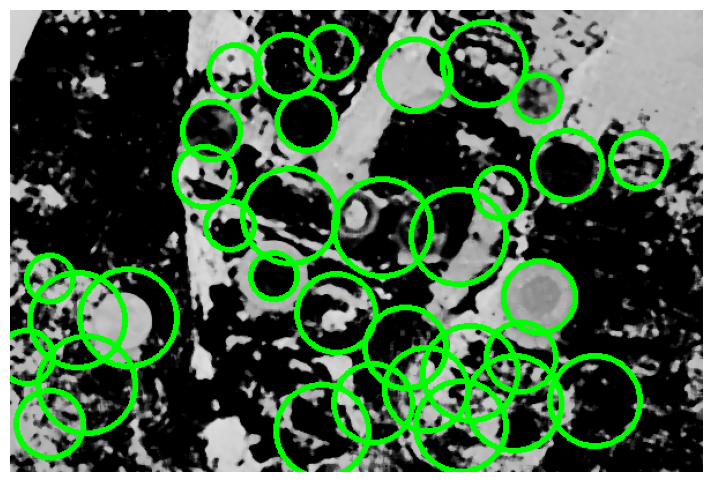

34


In [ ]:
circles = np.uint16(np.around(circles))

for (x, y, r) in circles[0, :]:
        cv.circle(cimg, (x, y), r, (0, 255, 0), 4)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(cimg)
plt.axis('off')  # Hide the axis
plt.show()

print(len(circles[0]))

### Filtered circles

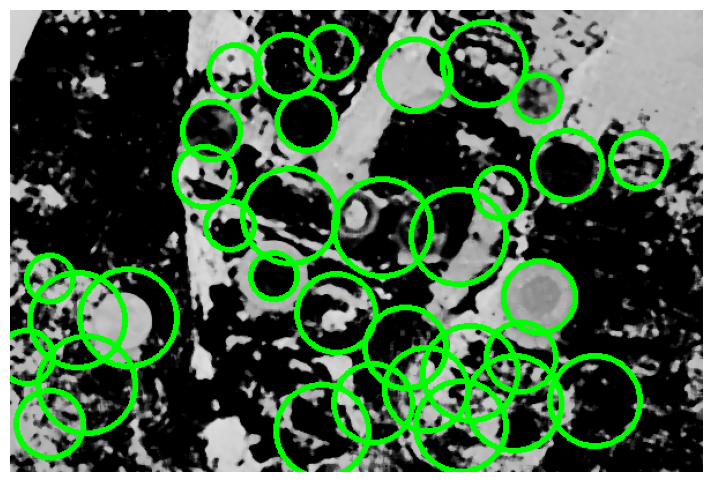

33


In [ ]:
circles_filt = filter_circles(circles)

for (x, y, r) in circles_filt:
        cv.circle(cimg, (x, y), r, (0, 255, 0), 4)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(cimg)
plt.axis('off')  # Hide the axis
plt.show()

print(len(circles_filt))

## Hough - Non noisy images

In [44]:
min_rad = 15
max_rad = 42

min_dist = 2 * min_rad

bg_type_dic = {1: 'hand', 2: 'noise', 3: 'neutral'}
bg_type = bg_type_dic[2]

split_dir_path = f'dataset_split/{bg_type}'
circles_dir_path = f'dataset_split/{bg_type}/{bg_type}_circles'
circles_sorted_path = f'dataset_split/{bg_type}/{bg_type}_circles_sorted'

hough_mode = 'grad'

for filename in os.listdir(split_dir_path):

	filepath = os.path.join(split_dir_path, filename)
	
	if os.path.isfile(filepath):
		
		# Open img and resize
		img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
		img_resized = resize_image(img, 10)
		img_blurred = cv.medianBlur(img_resized, 5)

		# Find circles with and without educated radii guess
		#circles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))

		if hough_mode == 'grad':
			circles = cv.HoughCircles(image=img_blurred,
					method=cv.HOUGH_GRADIENT_ALT,
					dp=1.25,
					minDist=min_dist,
					param1=50,
					param2=0.8,
					minRadius=min_rad,
					maxRadius=max_rad)
			
		if hough_mode == 'grad_alt':
			circles = cv.HoughCircles(image=img_blurred,
					method=cv.HOUGH_GRADIENT_ALT,
					dp=1.5,
					minDist=min_dist,
					param1=300,
					param2=0.9,
					minRadius=min_rad,
					maxRadius=max_rad)
		
		if circles is not None:
			# Sort circles
			circles_sorted = filter_circles(circles)

			# Check for sorted circles
			c_len = len(circles[0])
			c_s_len = len(circles_sorted)

			if c_len != c_s_len:
				print(f"{c_len} sorted to {c_s_len} in {filename}")

			# Add unsorted circles and save
			circles = np.uint16(np.around(circles))
			cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)
			for (x, y, r) in circles[0, :]:
				cv.imwrite(os.path.join(circles_dir_path, filename), cv.circle(cimg, (x, y), r, (0, 255, 0), 2))
			
			# Add sorted circles and save
			circles_sorted = np.uint16(np.around(circles_sorted))
			cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)
			for (x, y, r) in circles_sorted:	
				cv.imwrite(os.path.join(circles_sorted_path, filename), cv.circle(cimg, (x, y), r, (0, 255, 0), 2))

		

#circles = cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50)

5 sorted to 4 in L0000055.JPG
5 sorted to 4 in L0000089.JPG
6 sorted to 5 in L0000113.JPG


## Finding radii distribution

In [ ]:
min_rad = 15
max_rad = 42

circles = []
circles_prior = []

test_dir_path = 'test'
detect_dir_path = 'detect'

for filename in os.listdir(test_dir_path):
	filepath = os.path.join(test_dir_path, filename)
	
	if os.path.isfile(filepath):
		
		# Open img and resize
		img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
		img_resized = resize_image(img, 10)
		img_blurred = cv.medianBlur(img_resized, 5)
		cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

		# Find circles with and without educated radii guess
		circles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))
		c_prior = cv.HoughCircles(image=img_blurred, circles=cv.HOUGH_GRADIENT, method=1,  dp=20, minDist=min_rad, param1=70, param2=20, minRadius=min_rad, maxRadius=max_rad)
		circles_prior.append(c_prior)

		# Show circles on image and save
		c_prior_int = np.uint16(np.around(c_prior))

		for (x, y, r) in c_prior_int[0, :]:
			cv.imwrite(os.path.join(detect_dir_path, filename), cv.circle(cimg, (x, y), r, (0, 255, 0), 4))


		print(f"Done with {filename}")

#circles = cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:2338: error: (-5:Bad argument) Unrecognized method id. Actually supported methods are HOUGH_GRADIENT and HOUGH_GRADIENT_ALT in function 'cv::HoughCircles'


In [ ]:
radius_list = np.array([arr[0, -1, -1] for arr in circles])
radius_list_prior = np.array([arr[0, -1, -1] for arr in circles_prior])

In [ ]:
# bins
bin_size = 7

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram for source 1
axes[0].hist(radius_list, bins=bin_size, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Relaxed radius constraint')
axes[0].set_ylim([0, 80])

# Plot histogram for source 2
axes[1].hist(radius_list_prior, bins=bin_size, color='salmon', edgecolor='black')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Restrained radius constraint')
axes[1].set_ylim([0, 80])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
#from scipy import stats
#modes = stats.mode(radius_list_prior)
#modes.count